## Gene Expression RNA-Seq Classification 

**Pipeline**

2. &#9745; Data Preprocessing 
    - &#9745; Separate feature values from our target value
    - &#9745; Encode Labels 
    - &#9745; Data Normalization - Min-Max Scaling
    - &#9745; Split training and testing sets 
    - &#9745; Feature Selection 

3. Classification Models 
    - &#9745; One vs Rest Classifier
    - &#9745; Random Forest 
    - &#9744; SVC 
    - &#9744; Logistic Regression()
    - &#9744; K - Nearest Neighbors(KNN)
    - &#9744; Decision Tree
    - &#9744; Gradient Boosting 

Our clean data is currently in the wrong format to for our model. 

**Data Pre-processing is the process where we transform our data into a specific format that is suitable to run our ML algorithm.**

In [1]:
# Pre-processing 

# Functions
from functions import *

# Data Handling
import pandas as pd
import numpy as np

# Data Visualization 
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Categorical to Numeric
from sklearn.preprocessing import LabelEncoder

# Normalization
from sklearn.preprocessing import MinMaxScaler

# PCA
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_classif

# Classification Model
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.multiclass import OneVsRestClassifier
import lightgbm as lgb
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier





# Model Evaluation
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, matthews_corrcoef, ConfusionMatrixDisplay
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from itertools import cycle
from sklearn.preprocessing import label_binarize
import config



#### Load our Cleaned Data

In [2]:
cleaned_data = "/Users/kim/Desktop/repos/RNA-Seq_GeneExpression_Model/Datasets/Gene_Expression_Data.csv"

clean_gene_df = pd.read_csv(cleaned_data)
clean_gene_df.head()

,Class,gene_0,gene_1,gene_2,gene_3,gene_4,gene_5,gene_6,gene_7,gene_8,...,gene_20521,gene_20522,gene_20523,gene_20524,gene_20525,gene_20526,gene_20527,gene_20528,gene_20529,gene_20530
0,KIRC,0.053131,2.185391,2.129093,6.374629,9.551359,0.0,5.981269,0.000000,0.0,...,6.082999,8.448775,9.958614,4.297722,10.256597,11.956406,10.192791,9.106968,5.701753,0.049595
1,PRAD,0.000000,0.870955,3.010615,7.078216,10.104074,0.0,6.654744,0.000000,0.0,...,4.679887,8.025320,9.559705,5.069546,10.141775,13.193550,10.049186,8.888535,7.460064,0.000000
2,BRCA,0.000000,4.122805,2.939922,6.730137,9.508001,0.0,6.959306,0.845109,0.0,...,6.704111,9.459323,10.705149,6.782736,10.622290,11.136222,10.787837,10.416871,8.318724,0.000000
3,PRAD,0.000000,3.926882,4.990551,6.562079,8.970868,0.0,7.722753,0.443607,0.0,...,6.131768,8.759436,10.207222,5.534824,10.008779,11.233823,10.250073,9.933233,5.343422,0.000000
4,BRCA,0.000000,2.543372,2.564476,6.299157,9.783317,0.0,7.105542,1.443448,0.0,...,6.682967,9.629983,10.355946,7.365832,9.374287,11.050787,10.296698,10.552400,5.411399,0.363564


#### Encode Labels
ML models require numeric values as input. Our 'Class' column (target value) is categorical. 

We will be applying label encoding to convert this target value into a numeric form. 

In [3]:
# Encoder
LE = LabelEncoder()

# Fit the encoder and transform the data
clean_gene_df['class_encoded'] = LE.fit_transform(clean_gene_df['Class'])
labels = LE.classes_
print(labels)
print(np.unique(clean_gene_df['class_encoded']))

# Shift this column to the third column
last_column = clean_gene_df.iloc[:,-1]
clean_gene_df = clean_gene_df.drop(clean_gene_df.columns[-1], axis = 1)
clean_gene_df.insert(2, last_column.name, last_column)

['BRCA' 'COAD' 'KIRC' 'LUAD' 'PRAD']
[0 1 2 3 4]


In [4]:
clean_gene_df

,Class,gene_0,class_encoded,gene_1,gene_2,gene_3,gene_4,gene_5,gene_6,gene_7,...,gene_20521,gene_20522,gene_20523,gene_20524,gene_20525,gene_20526,gene_20527,gene_20528,gene_20529,gene_20530
0,KIRC,0.053131,2,2.185391,2.129093,6.374629,9.551359,0.0,5.981269,0.000000,...,6.082999,8.448775,9.958614,4.297722,10.256597,11.956406,10.192791,9.106968,5.701753,0.049595
1,PRAD,0.000000,4,0.870955,3.010615,7.078216,10.104074,0.0,6.654744,0.000000,...,4.679887,8.025320,9.559705,5.069546,10.141775,13.193550,10.049186,8.888535,7.460064,0.000000
2,BRCA,0.000000,0,4.122805,2.939922,6.730137,9.508001,0.0,6.959306,0.845109,...,6.704111,9.459323,10.705149,6.782736,10.622290,11.136222,10.787837,10.416871,8.318724,0.000000
3,PRAD,0.000000,4,3.926882,4.990551,6.562079,8.970868,0.0,7.722753,0.443607,...,6.131768,8.759436,10.207222,5.534824,10.008779,11.233823,10.250073,9.933233,5.343422,0.000000
4,BRCA,0.000000,0,2.543372,2.564476,6.299157,9.783317,0.0,7.105542,1.443448,...,6.682967,9.629983,10.355946,7.365832,9.374287,11.050787,10.296698,10.552400,5.411399,0.363564
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,KIRC,0.000000,2,1.776256,2.643057,6.047797,10.132871,0.0,7.719507,0.325400,...,5.297159,8.212336,9.625056,3.287073,9.612343,12.268147,9.629786,9.321581,4.270199,0.000000
1496,LUAD,0.000000,3,4.468543,4.617051,6.815985,9.311741,0.0,8.081579,0.569611,...,5.642629,8.445557,11.134638,2.305562,9.907993,11.777109,10.511230,9.419296,6.456342,0.390899
1497,COAD,0.000000,1,2.923804,3.602580,7.662982,9.745030,0.0,8.181426,0.006949,...,6.178705,9.072101,10.181527,0.003924,9.247646,12.365738,11.175087,9.752405,3.611730,0.000000
1498,PRAD,0.807538,4,1.973383,3.421670,6.032660,10.683836,0.0,7.844231,0.048950,...,5.045668,7.995329,9.605593,6.954292,8.837062,11.297516,9.618031,9.160208,7.597883,0.000000


#### Data Normalization 
To accurately compare the values of the expression level for each gene, the values needs to be normalized so they are all range within each other. 

In [5]:
norm_scaler = MinMaxScaler()

def scaling_normalization(df, norm_scaler):
    
    # Separate non-numeric cols and numeric_cols
    non_numeric_cols = df.select_dtypes(exclude = ['float64']).columns
    numeric_cols = df.select_dtypes(include = ['float64']).columns
    numeric_df = df[numeric_cols]

    # Creeate a MinMax Scaler object
    scaler = norm_scaler

    # Data Transformation
    min_max_array = scaler.fit_transform(numeric_df) # Outputs a numpy array

    # Convert it back to a dataframe
    norm_numeric_df = pd.DataFrame(min_max_array, columns = numeric_cols)
    norm_df = pd.concat([df[non_numeric_cols], norm_numeric_df], axis = 1)

    return norm_df

norm_gene_df = scaling_normalization(clean_gene_df, norm_scaler)
norm_gene_df

,Class,class_encoded,gene_0,gene_1,gene_2,gene_3,gene_4,gene_5,gene_6,gene_7,...,gene_20521,gene_20522,gene_20523,gene_20524,gene_20525,gene_20526,gene_20527,gene_20528,gene_20529,gene_20530
0,KIRC,2,0.035843,0.350389,0.351134,0.266656,0.382022,0.0,0.302105,0.000000,...,0.656728,0.399906,0.486698,0.466763,0.594694,0.623359,0.642297,0.251058,0.481327,0.009439
1,PRAD,4,0.000000,0.139642,0.496516,0.404069,0.571333,0.0,0.401329,0.000000,...,0.371399,0.304254,0.336097,0.550589,0.564766,0.888266,0.607656,0.206920,0.647020,0.000000
2,BRCA,0,0.000000,0.661020,0.484857,0.336088,0.367171,0.0,0.446200,0.304104,...,0.783033,0.628172,0.768538,0.736654,0.690008,0.447734,0.785837,0.515750,0.727935,0.000000
3,PRAD,4,0.000000,0.629607,0.823050,0.303266,0.183198,0.0,0.558680,0.159628,...,0.666645,0.470079,0.580555,0.601122,0.530102,0.468634,0.656115,0.418022,0.447560,0.000000
4,BRCA,0,0.000000,0.407786,0.422938,0.251916,0.461470,0.0,0.467745,0.519411,...,0.778733,0.666721,0.636703,0.799982,0.364727,0.429440,0.667362,0.543137,0.453966,0.069196
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,KIRC,2,0.000000,0.284792,0.435897,0.202825,0.581196,0.0,0.558201,0.117092,...,0.496924,0.346498,0.360769,0.357000,0.426774,0.690111,0.506486,0.294425,0.346426,0.000000
1496,LUAD,3,0.000000,0.716453,0.761452,0.352854,0.299950,0.0,0.611546,0.204969,...,0.567177,0.399179,0.930683,0.250401,0.503833,0.584966,0.719112,0.314170,0.552435,0.074398
1497,COAD,1,0.000000,0.468781,0.594144,0.518276,0.448356,0.0,0.626256,0.002501,...,0.676190,0.540705,0.570854,0.000426,0.331719,0.711008,0.879251,0.381482,0.284376,0.000000
1498,PRAD,4,0.544775,0.316398,0.564308,0.199869,0.769907,0.0,0.576577,0.017614,...,0.445782,0.297480,0.353421,0.755286,0.224704,0.482272,0.503651,0.261817,0.660007,0.000000


In [6]:
# Take out 20% of data (300) to be used to validate classification models
val_data = norm_gene_df.tail(400).copy()
norm_gene_df.drop(norm_gene_df.tail(400).index, inplace = True)
norm_gene_df

,Class,class_encoded,gene_0,gene_1,gene_2,gene_3,gene_4,gene_5,gene_6,gene_7,...,gene_20521,gene_20522,gene_20523,gene_20524,gene_20525,gene_20526,gene_20527,gene_20528,gene_20529,gene_20530
0,KIRC,2,0.035843,0.350389,0.351134,0.266656,0.382022,0.0,0.302105,0.000000,...,0.656728,0.399906,0.486698,0.466763,0.594694,0.623359,0.642297,0.251058,0.481327,0.009439
1,PRAD,4,0.000000,0.139642,0.496516,0.404069,0.571333,0.0,0.401329,0.000000,...,0.371399,0.304254,0.336097,0.550589,0.564766,0.888266,0.607656,0.206920,0.647020,0.000000
2,BRCA,0,0.000000,0.661020,0.484857,0.336088,0.367171,0.0,0.446200,0.304104,...,0.783033,0.628172,0.768538,0.736654,0.690008,0.447734,0.785837,0.515750,0.727935,0.000000
3,PRAD,4,0.000000,0.629607,0.823050,0.303266,0.183198,0.0,0.558680,0.159628,...,0.666645,0.470079,0.580555,0.601122,0.530102,0.468634,0.656115,0.418022,0.447560,0.000000
4,BRCA,0,0.000000,0.407786,0.422938,0.251916,0.461470,0.0,0.467745,0.519411,...,0.778733,0.666721,0.636703,0.799982,0.364727,0.429440,0.667362,0.543137,0.453966,0.069196
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1095,PRAD,4,0.000000,0.610010,0.841011,0.294668,0.406238,0.0,0.611143,0.002895,...,0.671057,0.473391,0.427809,0.715537,0.400044,0.555170,0.630216,0.397577,0.655007,0.000000
1096,KIRC,2,0.000000,0.270491,0.466131,0.160320,0.851146,0.0,0.192235,0.000000,...,0.614497,0.643099,0.390062,0.680199,0.608758,0.390063,0.325103,0.192699,0.267277,1.000000
1097,LUAD,3,0.000000,0.813923,0.724903,0.241957,0.413196,0.0,0.855775,0.194716,...,0.463871,0.343199,0.554219,0.859869,0.457245,0.560804,0.493298,0.362057,0.231423,0.000000
1098,KIRC,2,0.000000,0.664349,0.501994,0.234765,0.121902,0.0,0.554143,0.415583,...,0.891616,0.556860,0.685194,0.471885,0.644776,0.399890,0.685856,0.450545,0.307523,0.000000


#### Separate Feature Values from our Target Value


In [7]:
# Training Set
X = norm_gene_df.iloc[:,3:]
Y_encoded = norm_gene_df['class_encoded']

# Testing Set
X_val = val_data.iloc[:,3:]
Y_encoded_val = val_data['class_encoded']

# Save our values as a CSV 

subfolder_path = "/Users/kim/Desktop/repos/RNA-Seq_GeneExpression_Model/Datasets"

x_filename = "Training Set Features.csv"
y_filename = "Training Set Target.csv"
val_x_filename = "Validation Set Features.csv"
val_y_filename = "Validation Set Target.csv"

save_dataframe_to_csv(X, subfolder_path, x_filename)
save_dataframe_to_csv(Y_encoded, subfolder_path, y_filename)
save_dataframe_to_csv(X_val, subfolder_path, val_x_filename)
save_dataframe_to_csv(Y_encoded_val, subfolder_path, val_y_filename)

#### Split Data into Training and Testing Set 

In [8]:
# Split data into training and test sets
x_train, x_test, y_train, y_test = split_train_test_data(X, Y_encoded)

#### Feature Selection using PCA

In [9]:
# Apply PCA on the training set
pca = PCA()
X_train_pca = pca.fit_transform(x_train)

# Use the same PCA transformation on the test set
X_test_pca = pca.transform(x_test)

# Apply to our validation data
X_val_pca = pca.transform(X_val)

# Print the explained variance ratio for each principal component
explained_variance_ratio = pca.explained_variance_ratio_
print("Explained Variance Ratio for each Principal Component:")
print(explained_variance_ratio)

# Choose the number of components based on the desired explained variance
# For example, let's retain the top 2 components explaining 95% of the variance
k_components = np.argmax(np.cumsum(explained_variance_ratio) >= 0.95) + 1
print(f"Number of components to retain: {k_components}")

# Use the selected components for feature transformation
x_train_select = X_train_pca[:, :k_components]
x_test_select = X_test_pca[:, :k_components]
x_val_select = X_val_pca[:, :k_components]


Explained Variance Ratio for each Principal Component:
[1.72160065e-01 1.32978810e-01 7.77059083e-02 5.79178924e-02
 4.38812269e-02 2.69821352e-02 2.25267916e-02 1.94017778e-02
 1.28995469e-02 1.22910877e-02 9.82882576e-03 8.72417014e-03
 8.33513676e-03 7.74206825e-03 7.04741442e-03 6.19923768e-03
 5.55852317e-03 5.12066389e-03 4.97911663e-03 4.76760827e-03
 4.57548814e-03 4.27065525e-03 4.19606231e-03 3.94019829e-03
 3.80789650e-03 3.69471563e-03 3.61362516e-03 3.55558438e-03
 3.32430681e-03 3.22661463e-03 3.11983945e-03 3.01594603e-03
 2.94147350e-03 2.92377677e-03 2.84418460e-03 2.82382776e-03
 2.69436237e-03 2.62325348e-03 2.61321718e-03 2.50914706e-03
 2.47505329e-03 2.42265129e-03 2.37539550e-03 2.34511111e-03
 2.26845505e-03 2.23996379e-03 2.21175277e-03 2.17640119e-03
 2.11197404e-03 2.09121413e-03 2.02765379e-03 1.97684794e-03
 1.95625438e-03 1.93569846e-03 1.85892442e-03 1.83893054e-03
 1.81364208e-03 1.79882342e-03 1.76905042e-03 1.74070469e-03
 1.71607001e-03 1.68890292e-03

#### Classification Models and Evaluation

Train our models 
- Random Forest 
- Linear SVC 
- Logistic Regression() 
- K - Nearest Neighbors(KNN) 
- Decision Tree 
- Gradient Boosting 

The metrics are:
- accuracy
- precision
- recall
- f1 score
- confusion matrix
- ROC curve

#### Random Forest

In [12]:
# Instantiate the model 
rf_ovr_model = OneVsRestClassifier(RandomForestClassifier(random_state = 42))

# Train the model
rf_ovr_model.fit(x_train_select, y_train)

# Make predictions on the test set
rf_test_pred = rf_ovr_model.predict(x_test_select)
rf_test_pred_proba = rf_ovr_model.predict_proba(x_test_select)

# Make predictions for another set of data to validate model
rf_val_pred = rf_ovr_model.predict(x_val_select)
rf_val_pred_proba = rf_ovr_model.predict_proba(x_val_select)

Balanced Accuracy: 1.0000
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
f1 score: 1.0000


Classification Report

              precision    recall  f1-score   support

        BRCA       1.00      1.00      1.00        41
        COAD       1.00      1.00      1.00        43
        KIRC       1.00      1.00      1.00        48
        LUAD       1.00      1.00      1.00        47
        PRAD       1.00      1.00      1.00        41

    accuracy                           1.00       220
   macro avg       1.00      1.00      1.00       220
weighted avg       1.00      1.00      1.00       220

      BRCA  COAD  KIRC  LUAD  PRAD
BRCA    41     0     0     0     0
COAD     0    43     0     0     0
KIRC     0     0    48     0     0
LUAD     0     0     0    47     0
PRAD     0     0     0     0    41


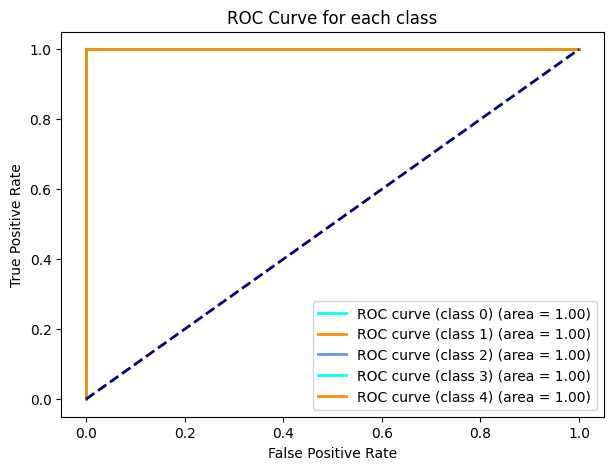

Balanced Accuracy: 0.9973
Accuracy: 0.9975
Precision: 0.9975
Recall: 0.9975
f1 score: 0.9975


Classification Report

              precision    recall  f1-score   support

        BRCA       1.00      1.00      1.00        75
        COAD       1.00      0.99      0.99        73
        KIRC       1.00      1.00      1.00        75
        LUAD       0.99      1.00      0.99        96
        PRAD       1.00      1.00      1.00        81

    accuracy                           1.00       400
   macro avg       1.00      1.00      1.00       400
weighted avg       1.00      1.00      1.00       400

      BRCA  COAD  KIRC  LUAD  PRAD
BRCA    75     0     0     0     0
COAD     0    72     0     1     0
KIRC     0     0    75     0     0
LUAD     0     0     0    96     0
PRAD     0     0     0     0    81


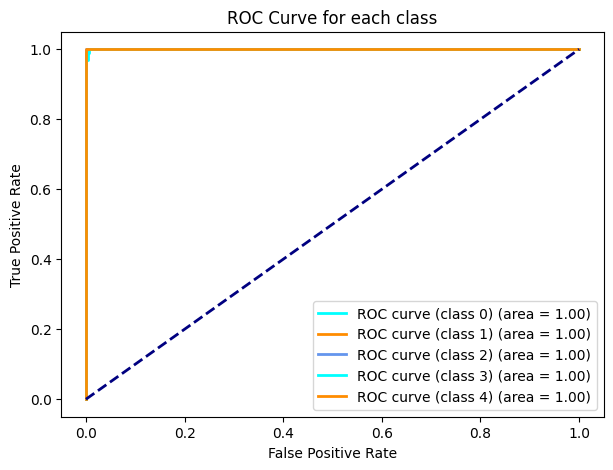

In [13]:
# Random Forest Test
model_evaluate(y_test, rf_test_pred, labels, rf_test_pred_proba)

# Random Forest Validation
model_evaluate(Y_encoded_val, rf_val_pred, labels, rf_val_pred_proba)

#### Linear SVC

In [14]:
# Instantiate the model 
svc_ovr_model = OneVsRestClassifier(SVC(kernel='linear', probability=True, random_state = 42))

# Train the model
svc_ovr_model.fit(x_train_select, y_train)

# Make predictions on the test set
svc_test_pred = svc_ovr_model.predict(x_test_select)
svc_test_pred_proba = svc_ovr_model.predict_proba(x_test_select)

# Make predictions for another set of data to validate model
svc_val_pred = svc_ovr_model.predict(x_val_select)
svc_val_pred_proba = svc_ovr_model.predict_proba(x_val_select)

Balanced Accuracy: 1.0000
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
f1 score: 1.0000


Classification Report

              precision    recall  f1-score   support

        BRCA       1.00      1.00      1.00        41
        COAD       1.00      1.00      1.00        43
        KIRC       1.00      1.00      1.00        48
        LUAD       1.00      1.00      1.00        47
        PRAD       1.00      1.00      1.00        41

    accuracy                           1.00       220
   macro avg       1.00      1.00      1.00       220
weighted avg       1.00      1.00      1.00       220

      BRCA  COAD  KIRC  LUAD  PRAD
BRCA    41     0     0     0     0
COAD     0    43     0     0     0
KIRC     0     0    48     0     0
LUAD     0     0     0    47     0
PRAD     0     0     0     0    41


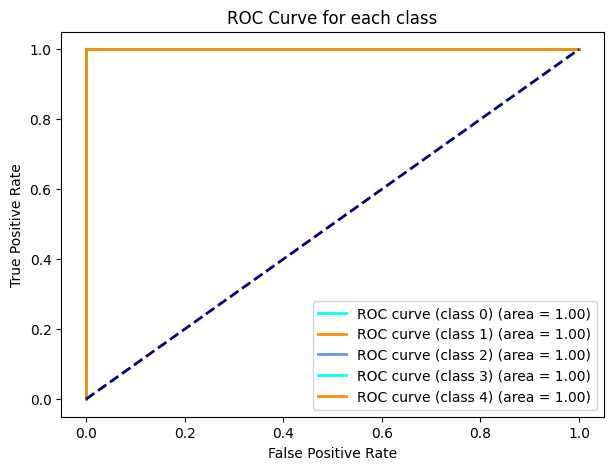

Balanced Accuracy: 1.0000
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
f1 score: 1.0000


Classification Report

              precision    recall  f1-score   support

        BRCA       1.00      1.00      1.00        75
        COAD       1.00      1.00      1.00        73
        KIRC       1.00      1.00      1.00        75
        LUAD       1.00      1.00      1.00        96
        PRAD       1.00      1.00      1.00        81

    accuracy                           1.00       400
   macro avg       1.00      1.00      1.00       400
weighted avg       1.00      1.00      1.00       400

      BRCA  COAD  KIRC  LUAD  PRAD
BRCA    75     0     0     0     0
COAD     0    73     0     0     0
KIRC     0     0    75     0     0
LUAD     0     0     0    96     0
PRAD     0     0     0     0    81


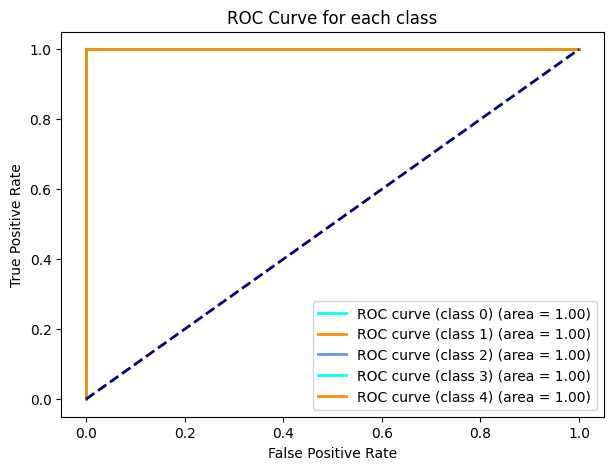

In [15]:
# Test Set
model_evaluate(y_test, svc_test_pred, labels, svc_test_pred_proba)

# Validation Set
model_evaluate(Y_encoded_val, svc_val_pred, labels, svc_val_pred_proba)

#### Logistic Regression 

In [16]:
# Instantiate the model 
lr_ovr_model = OneVsRestClassifier(LogisticRegression(max_iter=1000, random_state = 42))

# Train the model
lr_ovr_model.fit(x_train_select, y_train)

# Make predictions on the test set
lr_test_pred = lr_ovr_model.predict(x_test_select)
lr_test_pred_proba = lr_ovr_model.predict_proba(x_test_select)

# Make predictions for another set of data to validate model
lr_val_pred = lr_ovr_model.predict(x_val_select)
lr_val_pred_proba = lr_ovr_model.predict_proba(x_val_select)

Balanced Accuracy: 1.0000
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
f1 score: 1.0000


Classification Report

              precision    recall  f1-score   support

        BRCA       1.00      1.00      1.00        41
        COAD       1.00      1.00      1.00        43
        KIRC       1.00      1.00      1.00        48
        LUAD       1.00      1.00      1.00        47
        PRAD       1.00      1.00      1.00        41

    accuracy                           1.00       220
   macro avg       1.00      1.00      1.00       220
weighted avg       1.00      1.00      1.00       220

      BRCA  COAD  KIRC  LUAD  PRAD
BRCA    41     0     0     0     0
COAD     0    43     0     0     0
KIRC     0     0    48     0     0
LUAD     0     0     0    47     0
PRAD     0     0     0     0    41


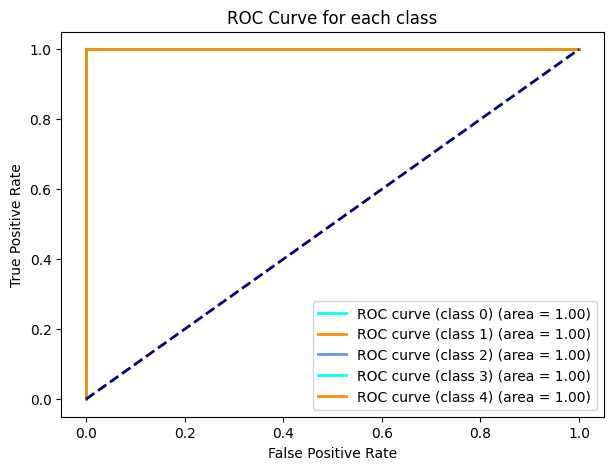

Balanced Accuracy: 1.0000
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
f1 score: 1.0000


Classification Report

              precision    recall  f1-score   support

        BRCA       1.00      1.00      1.00        75
        COAD       1.00      1.00      1.00        73
        KIRC       1.00      1.00      1.00        75
        LUAD       1.00      1.00      1.00        96
        PRAD       1.00      1.00      1.00        81

    accuracy                           1.00       400
   macro avg       1.00      1.00      1.00       400
weighted avg       1.00      1.00      1.00       400

      BRCA  COAD  KIRC  LUAD  PRAD
BRCA    75     0     0     0     0
COAD     0    73     0     0     0
KIRC     0     0    75     0     0
LUAD     0     0     0    96     0
PRAD     0     0     0     0    81


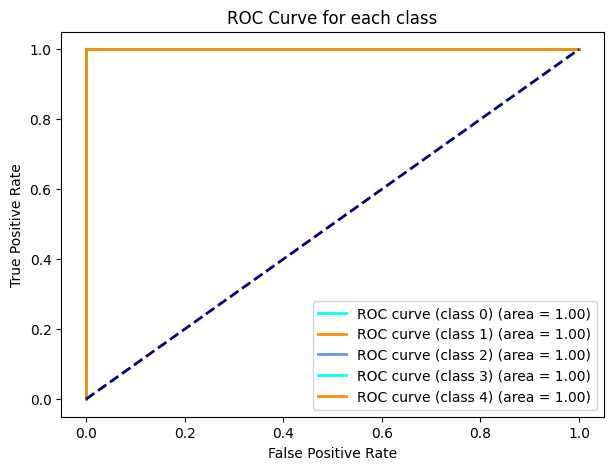

In [17]:
# Test Set
model_evaluate(y_test, lr_test_pred, labels, lr_test_pred_proba)

# Validation Set
model_evaluate(Y_encoded_val, lr_val_pred, labels, lr_val_pred_proba)

#### K-Nearest Neighbors (KNN)

In [18]:
# Instantiate the model 
knn_ovr_model = OneVsRestClassifier(KNeighborsClassifier(n_neighbors=5))

# Train the model
knn_ovr_model.fit(x_train_select, y_train)

# Make predictions on the test set
knn_test_pred = knn_ovr_model.predict(x_test_select)
knn_test_pred_proba = knn_ovr_model.predict_proba(x_test_select)

# Make predictions for another set of data to validate model
knn_val_pred = knn_ovr_model.predict(x_val_select)
knn_val_pred_proba = knn_ovr_model.predict_proba(x_val_select)

Balanced Accuracy: 1.0000
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
f1 score: 1.0000


Classification Report

              precision    recall  f1-score   support

        BRCA       1.00      1.00      1.00        41
        COAD       1.00      1.00      1.00        43
        KIRC       1.00      1.00      1.00        48
        LUAD       1.00      1.00      1.00        47
        PRAD       1.00      1.00      1.00        41

    accuracy                           1.00       220
   macro avg       1.00      1.00      1.00       220
weighted avg       1.00      1.00      1.00       220

      BRCA  COAD  KIRC  LUAD  PRAD
BRCA    41     0     0     0     0
COAD     0    43     0     0     0
KIRC     0     0    48     0     0
LUAD     0     0     0    47     0
PRAD     0     0     0     0    41


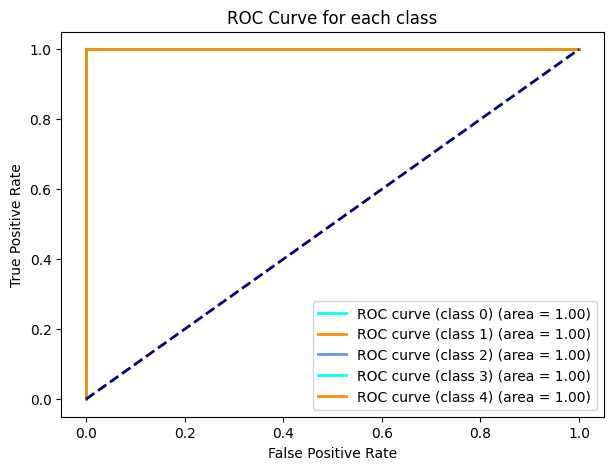

Balanced Accuracy: 0.9979
Accuracy: 0.9975
Precision: 0.9975
Recall: 0.9975
f1 score: 0.9975


Classification Report

              precision    recall  f1-score   support

        BRCA       0.99      1.00      0.99        75
        COAD       1.00      1.00      1.00        73
        KIRC       1.00      1.00      1.00        75
        LUAD       1.00      0.99      0.99        96
        PRAD       1.00      1.00      1.00        81

    accuracy                           1.00       400
   macro avg       1.00      1.00      1.00       400
weighted avg       1.00      1.00      1.00       400

      BRCA  COAD  KIRC  LUAD  PRAD
BRCA    75     0     0     0     0
COAD     0    73     0     0     0
KIRC     0     0    75     0     0
LUAD     1     0     0    95     0
PRAD     0     0     0     0    81


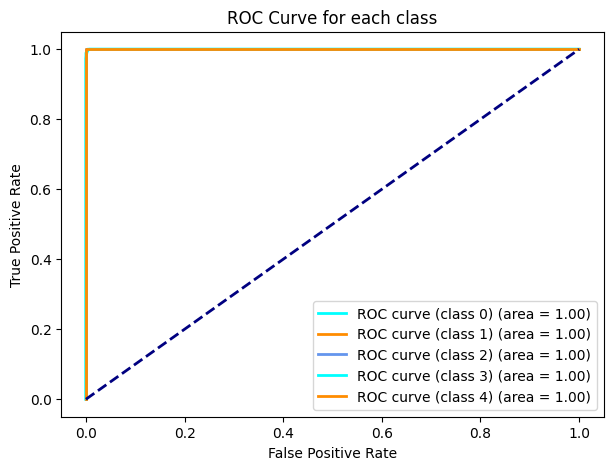

In [19]:
# Test Set
model_evaluate(y_test, knn_test_pred, labels, knn_test_pred_proba)

# Validation Set
model_evaluate(Y_encoded_val, knn_val_pred, labels, knn_val_pred_proba)

#### Gaussian NB

In [20]:
# Instantiate the model 
gnb_ovr_model = OneVsRestClassifier( GaussianNB())

# Train the model
gnb_ovr_model.fit(x_train_select, y_train)

# Make predictions on the test set
gnb_test_pred = gnb_ovr_model.predict(x_test_select)
gnb_test_pred_proba = gnb_ovr_model.predict_proba(x_test_select)

# Make predictions for another set of data to validate model
gnb_val_pred = gnb_ovr_model.predict(x_val_select)
gnb_val_pred_proba = gnb_ovr_model.predict_proba(x_val_select)

Balanced Accuracy: 0.6883
Accuracy: 0.6955
Precision: 0.6205
Recall: 0.6955
f1 score: 0.6349


Classification Report

              precision    recall  f1-score   support

        BRCA       0.00      0.00      0.00        41
        COAD       0.66      0.93      0.77        43
        KIRC       1.00      0.98      0.99        48
        LUAD       0.81      0.53      0.64        47
        PRAD       0.55      1.00      0.71        41

    accuracy                           0.70       220
   macro avg       0.60      0.69      0.62       220
weighted avg       0.62      0.70      0.63       220

      BRCA  COAD  KIRC  LUAD  PRAD
BRCA     0     5     0     5    31
COAD     2    40     0     1     0
KIRC     1     0    47     0     0
LUAD     3    16     0    25     3
PRAD     0     0     0     0    41


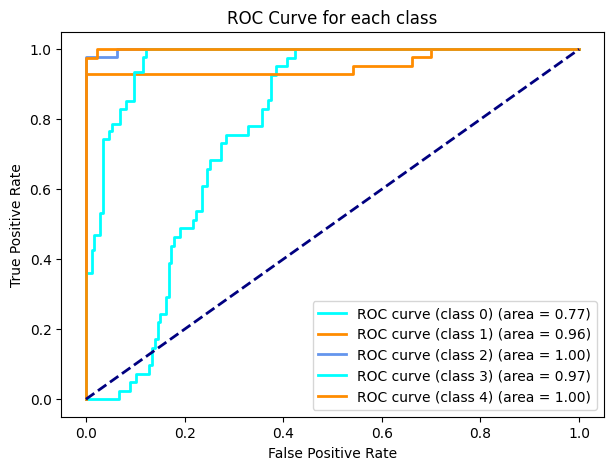

Balanced Accuracy: 0.6807
Accuracy: 0.6775
Precision: 0.6228
Recall: 0.6775
f1 score: 0.6270


Classification Report

              precision    recall  f1-score   support

        BRCA       0.05      0.01      0.02        75
        COAD       0.65      0.96      0.78        73
        KIRC       1.00      0.89      0.94        75
        LUAD       0.79      0.56      0.66        96
        PRAD       0.57      0.98      0.72        81

    accuracy                           0.68       400
   macro avg       0.61      0.68      0.62       400
weighted avg       0.62      0.68      0.63       400

      BRCA  COAD  KIRC  LUAD  PRAD
BRCA     1     8     0    12    54
COAD     2    70     0     1     0
KIRC     6     1    67     1     0
LUAD     9    28     0    54     5
PRAD     2     0     0     0    79


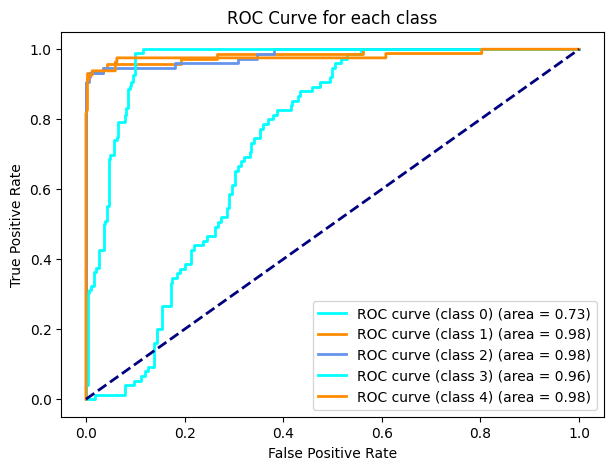

In [21]:
# Test Set
model_evaluate(y_test, gnb_test_pred, labels, gnb_test_pred_proba)

# Validation Set
model_evaluate(Y_encoded_val, gnb_val_pred, labels, gnb_val_pred_proba)

#### ADA Boost Classifier

In [22]:
# Instantiate the model 
ada_ovr_model = OneVsRestClassifier(AdaBoostClassifier(n_estimators=50, random_state=42))

# Train the model
ada_ovr_model.fit(x_train_select, y_train)

# Make predictions on the test set
ada_test_pred = ada_ovr_model.predict(x_test_select)
ada_test_pred_proba = ada_ovr_model.predict_proba(x_test_select)

# Make predictions for another set of data to validate model
ada_val_pred = ada_ovr_model.predict(x_val_select)
ada_val_pred_proba = ada_ovr_model.predict_proba(x_val_select)

Balanced Accuracy: 0.9912
Accuracy: 0.9909
Precision: 0.9911
Recall: 0.9909
f1 score: 0.9909


Classification Report

              precision    recall  f1-score   support

        BRCA       0.98      1.00      0.99        41
        COAD       1.00      0.98      0.99        43
        KIRC       1.00      0.98      0.99        48
        LUAD       0.98      1.00      0.99        47
        PRAD       1.00      1.00      1.00        41

    accuracy                           0.99       220
   macro avg       0.99      0.99      0.99       220
weighted avg       0.99      0.99      0.99       220

      BRCA  COAD  KIRC  LUAD  PRAD
BRCA    41     0     0     0     0
COAD     0    42     0     1     0
KIRC     1     0    47     0     0
LUAD     0     0     0    47     0
PRAD     0     0     0     0    41


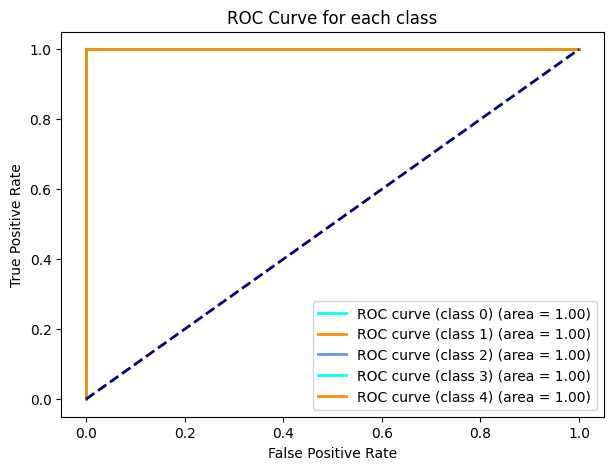

Balanced Accuracy: 0.9837
Accuracy: 0.9825
Precision: 0.9829
Recall: 0.9825
f1 score: 0.9825


Classification Report

              precision    recall  f1-score   support

        BRCA       0.95      0.99      0.97        75
        COAD       0.99      1.00      0.99        73
        KIRC       0.99      0.97      0.98        75
        LUAD       1.00      0.96      0.98        96
        PRAD       0.99      1.00      0.99        81

    accuracy                           0.98       400
   macro avg       0.98      0.98      0.98       400
weighted avg       0.98      0.98      0.98       400

      BRCA  COAD  KIRC  LUAD  PRAD
BRCA    74     0     0     0     1
COAD     0    73     0     0     0
KIRC     2     0    73     0     0
LUAD     2     1     1    92     0
PRAD     0     0     0     0    81


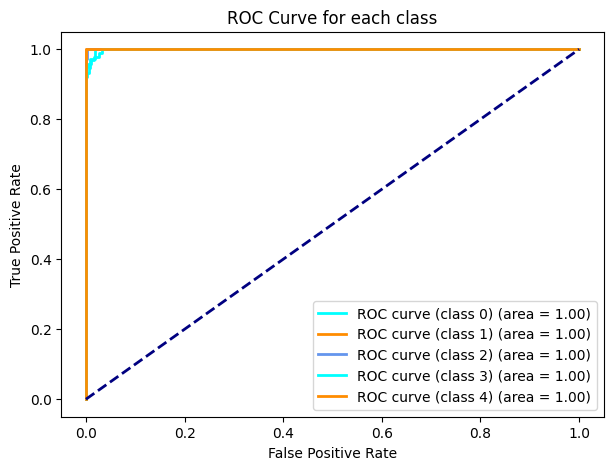

In [23]:
# Test Set
model_evaluate(y_test, ada_test_pred, labels, ada_test_pred_proba)

# Validation Set
model_evaluate(Y_encoded_val, ada_val_pred, labels, ada_val_pred_proba)

#### Decision Tree 

In [24]:
# Instantiate the model 
dt_ovr_model = OneVsRestClassifier(DecisionTreeClassifier())

# Train the model
dt_ovr_model.fit(x_train_select, y_train)

# Make predictions on the test set
dt_test_pred = dt_ovr_model.predict(x_test_select)
dt_test_pred_proba = dt_ovr_model.predict_proba(x_test_select)

# Make predictions for another set of data to validate model
dt_val_pred = dt_ovr_model.predict(x_val_select)
dt_val_pred_proba = dt_ovr_model.predict_proba(x_val_select)

/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/multiclass.py:487: RuntimeWarning: invalid value encountered in true_divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]
/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/multiclass.py:487: RuntimeWarning: invalid value encountered in true_divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


In [25]:
# Test Set
model_evaluate(y_test, dt_test_pred, labels, dt_test_pred_proba)

# Validation Set
model_evaluate(Y_encoded_val, dt_val_pred, labels, dt_val_pred_proba)

Balanced Accuracy: 0.9501
Accuracy: 0.9500
Precision: 0.9555
Recall: 0.9500
f1 score: 0.9508


Classification Report

              precision    recall  f1-score   support

        BRCA       1.00      0.90      0.95        41
        COAD       0.98      0.95      0.96        43
        KIRC       0.98      0.96      0.97        48
        LUAD       0.98      0.94      0.96        47
        PRAD       0.84      1.00      0.91        41

    accuracy                           0.95       220
   macro avg       0.95      0.95      0.95       220
weighted avg       0.96      0.95      0.95       220

      BRCA  COAD  KIRC  LUAD  PRAD
BRCA    37     1     1     1     1
COAD     0    41     0     0     2
KIRC     0     0    46     0     2
LUAD     0     0     0    44     3
PRAD     0     0     0     0    41


ValueError: Input contains NaN.